# Red-Black Trees

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from gvdot import Dot, Nonce, ID

# Example images are saved to images/ if it exists.
import os; save_images = os.path.isdir("images")

Our goal is to produce examples for students learning about Robert Sedgewick's
[Left-leaning Red-Black
Trees](https://sedgewick.io/wp-content/themes/sedgewick/papers/2008LLRB.pdf).

As usual, we begin by creating a theme.

In [2]:
rb_theme = (Dot()
    .all_default(penwidth=1.5)
    .node_default(fontname="Helvetica", fontsize=14, fontcolor="#eeeeee",
                  style="filled", shape="circle", fixedsize=True, height=0.35)
    .edge_default(arrowhead="none")
    .node_role("red", fillcolor="#f31020")
    .node_role("black", fillcolor="#001122")
    .edge_role("phantom", style="invisible"))

Before we write the generation code, let's see how this looks by building a
tree by hand.  To ensure ``dot`` lays out the tree correctly, we use subgraphs
and phantom (invisible) edges to ensure sibling nodes are on the same rank
and ordered correctly.

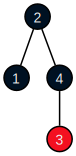

In [3]:
dot = Dot(directed=True).use_theme(rb_theme)
dot.node(2, role="black")
dot.node(1, role="black")
dot.node(4, role="black")
dot.node(3, role="red")
dot.edge(2, 1)
dot.edge(2, 4)
dot.edge(4, 3)
dot.subgraph().graph(rank="same").edge(1, 4, role="phantom")
dot.show()

if save_images:
    dot.save("images/rb-hand-initial.svg")

The nodes are nice, but the children of ``2`` are crowded, and we can't
visually determine if ``3`` is the left or right child of ``4``.  We will solve
these problems by adding phantom nodes --- every parent will have three
children, including at least one phantom.  

We add a phantom node role to the theme, joining the existing phantom edge role

In [4]:
rb_theme.node_role("phantom", style="invisible", label="")
None

and use it in our hand-crafted tree.

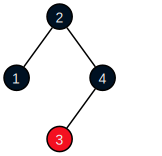

In [5]:
dot = Dot(directed=True).use_theme(rb_theme)
dot.node(2,role="black")
dot.node(1,role="black")
dot.node(4,role="black")
dot.node(3,role="red")
dot.node("phantom_1", role="phantom") # Child of 2, between 1 and 4
dot.node("phantom_2", role="phantom") # Child of 4, right of 3
dot.node("phantom_3", role="phantom") # Child of 4, rightmost

dot.edge(2,1)
dot.edge(2,"phantom_1", role="phantom")
dot.edge(2,4)
(dot.subgraph().graph(rank="same")
 .edge(1, "phantom_1", role="phantom")
 .edge("phantom_1", 4, role="phantom"))

dot.edge(4,3)
dot.edge(4,"phantom_2", role="phantom")
dot.edge(4,"phantom_3", role="phantom")
(dot.subgraph().graph(rank="same")
 .edge(3, "phantom_2", role="phantom")
 .edge("phantom_2", "phantom_3", role="phantom"))

dot.show()

if save_images:
    dot.save("images/rb-hand-updated.svg")


Much better, but tedious to construct by hand.  Time to automate.  

We create a simple red-black tree implementation based on Sedgewick's paper.

In [6]:
RED   = 1
BLACK = 0

@dataclass
class RBNode:
    key    : int
    color  : int = RED
    left   : RBNode | None = None
    right  : RBNode | None = None

@dataclass
class RBTree:
    root : RBNode | None = None

    def insert(self, key:int) -> None:
        self.root = _insert_node(self.root, key)
        self.root.color = BLACK

def _is_red(node:RBNode|None):
    return node is not None and node.color == RED

def _insert_node(node:RBNode|None, key:int) -> RBNode:

    if node is None:
        return RBNode(key)

    if _is_red(node.left) and _is_red(node.right):
        assert node.color == BLACK
        assert node.left is not None and node.right is not None
        node.color = RED
        node.left.color = BLACK
        node.right.color = BLACK

    if key < node.key:
        node.left = _insert_node(node.left, key)
    elif key > node.key:
        node.right = _insert_node(node.right, key)

    if _is_red(node.right) and not _is_red(node.left):
        node = _rotate_left(node)

    if _is_red(node.left):
        assert node.left is not None
        if _is_red(node.left.left):
            node = _rotate_right(node)

    return node

def _rotate_left(node:RBNode) -> RBNode:
    right = node.right
    assert right is not None
    node.right = right.left
    right.left = node
    right.color = node.color
    node.color = RED
    return right

def _rotate_right(node:RBNode) -> RBNode:
    left = node.left
    assert left is not None
    node.left = left.right
    left.right = node
    left.color = node.color
    node.color = RED
    return left

Now we write the generation code.  

In [7]:
def rb_diagram(tree:RBTree) -> Dot:
    #
    # Yield tree nodes in pre-order sequence.
    #
    def traverse(node):
        if node:
            yield node
            yield from traverse(node.left)
            yield from traverse(node.right)
    #
    # Add a child of node to the diagram, a phantom if child is None.
    #
    def link(node:RBNode, child:RBNode|None) -> ID:
        if child is not None:
            dot.edge(node.key, child.key)
            return child.key
        else:
            phantom_id = Nonce("phantom")
            dot.node(phantom_id, role="phantom")
            dot.edge(node.key, phantom_id, role="phantom")
            return phantom_id
    #
    # Build the diagram with every node and tree edge, including phantoms.
    #
    dot = Dot(directed=True).use_theme(rb_theme)
    for node in traverse(tree.root):
        dot.node(node.key, role="red" if node.color == RED else "black")
        if node.left or node.right:
            c1 = link(node, node.left)
            c2 = link(node, None)
            c3 = link(node, node.right)
            block = dot.subgraph().graph(rank="same")
            block.edge(c1,c2,role="phantom").edge(c2,c3,role="phantom")

    return dot

All that is left is generating our examples.

#### We start with 71:

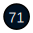

#### After inserting 59:

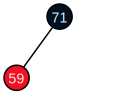

#### After inserting 58:

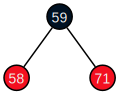

#### After inserting 51:

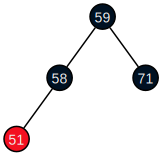

#### After inserting 43:

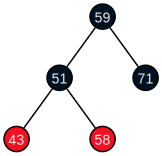

#### After inserting 34:

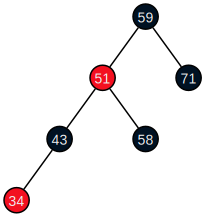

#### After inserting 18:

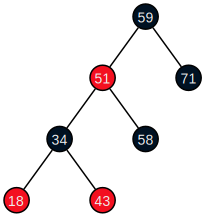

In [8]:
from IPython.display import display, Markdown

sequence = [ 71, 59, 58, 51, 43, 34, 18 ]

tree = RBTree()
tree.insert(sequence[0])

display(Markdown(f"#### We start with {sequence[0]}:"))
diagram = rb_diagram(tree)
diagram.show()
if save_images:
    diagram.save(f"images/rb-auto-{sequence[0]}.svg")
for key in sequence[1:]:
    tree.insert(key)
    display(Markdown(f"#### After inserting {key}:"))
    diagram = rb_diagram(tree)
    diagram.show()
    if save_images:
        diagram.save(f"images/rb-auto-{key}.svg")

The DOT language of our final tree diagram is

In [9]:
diagram.show_source()

digraph {

    graph [penwidth=1.5]
    node [penwidth=1.5 fontname=Helvetica fontsize=14 fontcolor="#eeeeee" style=filled shape=circle fixedsize=true height=0.35]
    edge [penwidth=1.5 arrowhead=none]

    59 [fillcolor="#001122"]
    phantom_1 [style=invisible label=""]
    51 [fillcolor="#f31020"]
    phantom_2 [style=invisible label=""]
    34 [fillcolor="#001122"]
    phantom_3 [style=invisible label=""]
    18 [fillcolor="#f31020"]
    43 [fillcolor="#f31020"]
    58 [fillcolor="#001122"]
    71 [fillcolor="#001122"]

    59 -> 51
    59 -> phantom_1 [style=invisible]
    59 -> 71
    51 -> 34
    51 -> phantom_2 [style=invisible]
    51 -> 58
    34 -> 18
    34 -> phantom_3 [style=invisible]
    34 -> 43

    subgraph {
        rank=same
        51 -> phantom_1 [style=invisible]
        phantom_1 -> 71 [style=invisible]
    }

    subgraph {
        rank=same
        34 -> phantom_2 [style=invisible]
        phantom_2 -> 58 [style=invisible]
    }

    subgraph {
        rank=same
        18 -> phantom_3 [style=invisible]
        phantom_3 -> 43 [style=invisible]
    }
}

To better understand what the phantoms contributed, we can make them visible.
We don't need to modify the diagram; we just amend the phantom roles in the
theme.

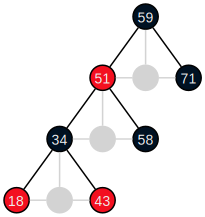

In [10]:
rb_theme.node_role("phantom", style=None, color="lightgray")
rb_theme.edge_role("phantom", style=None, color="lightgray")
diagram.show()

if save_images:
    diagram.save("images/rb-auto-phantoms.svg")